In [12]:
import pandas as pd
import seaborn as sns
import time
import xgboost
import numpy as np
import matplotlib.pyplot as plt
import xgboost

from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, accuracy_score

from src.modelling import hyperparameter_optimization

sns.set_theme(style="whitegrid")
sns.set_palette(palette="Paired")
SEED: int = 42

# Load Data

In [13]:
X_train = pd.read_csv("../../data/processed/train_data_cleaned.csv", index_col="building_id")
y_train = pd.read_csv("../../data/processed/train_labels.csv", index_col="building_id", usecols=["building_id", "damage_grade"])

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

X_train.head(5)

Shape of X_train: (260601, 18)
Shape of y_train: (260601, 1)


,count_families,count_floors_pre_eq,geo_level_1_id,geo_level_2_id,geo_level_3_id,has_secondary_use,has_superstructure_cement_mortar_brick,has_superstructure_mud_mortar_stone,age,area_percentage,superstructure_quality,foundation_type_r,ground_floor_type_f,ground_floor_type_v,land_surface_condition_t,other_floor_type_q,position_s,roof_type_n
building_id,,,,,,,,,,,,,,,,,,
802906,0.111111,0.125,0.200000,0.341275,0.970637,0.0,0.0,1.0,0.121343,0.247589,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
28830,0.111111,0.125,0.266667,0.630694,0.223761,0.0,0.0,1.0,0.040448,0.346625,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
94947,0.111111,0.125,0.700000,0.254380,0.714013,0.0,0.0,1.0,0.040448,0.198071,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
590882,0.111111,0.125,0.733333,0.292922,0.850959,0.0,0.0,1.0,0.040448,0.247589,0.5,1.0,1.0,0.0,1.0,0.0,1.0,1.0
201944,0.111111,0.250,0.366667,0.091801,0.118405,0.0,0.0,0.0,0.121343,0.346625,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0


In [14]:
# Take subsample for better runtime
X_train = X_train.iloc[:100000]
y_train = y_train.iloc[:100000]

# Get validation set to test SMOTE
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, stratify=y_train, test_size=0.2)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (75000, 18)
Shape of y_train: (75000, 1)


# Base: Target Distribution

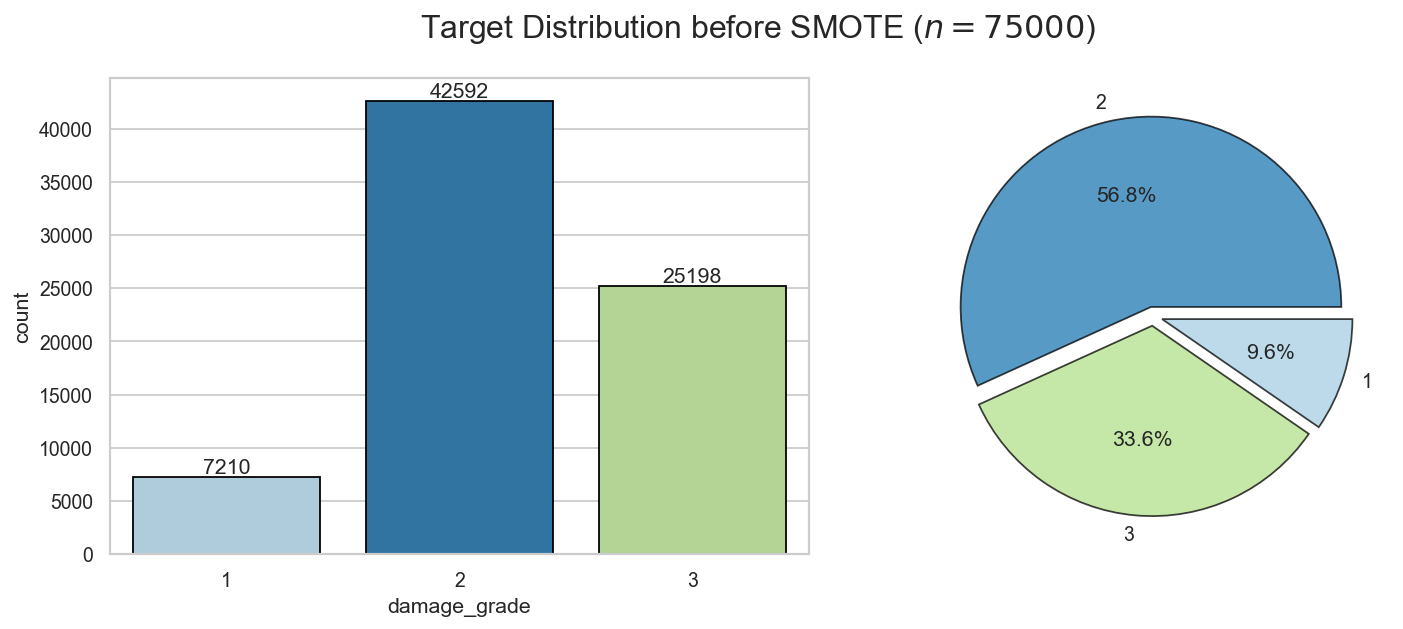

In [15]:
def plot_target_distribution(y_train: pd.DataFrame, title:str = "Target Distribution") -> None:
    """
    Expects single dataframe with only one column to analyse, i.e. target distribution
    :param y_train:
    :return:
    """
    # Get dict of winner with keys and corresponding values for plotting
    y_train_value_counts = y_train.value_counts()

    # Plot settings for winner distribution (barplot and pie chart)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=128)
    fig.suptitle(f"{title} ($n = {sum(y_train_value_counts.values)}$)",
                 size=18)
    g = sns.countplot(data=y_train, x="damage_grade", edgecolor="black", ax=axes[0], palette="Paired")
    g.bar_label(g.containers[0])
    axes[1].pie(x=y_train_value_counts,
                autopct='%1.1f%%',
                wedgeprops={"edgecolor":"black", "alpha": 0.75},
                labels=[int(x[0]) for x in y_train_value_counts.keys()],
                explode = np.full(shape=(len(y_train_value_counts.keys())), fill_value=0.05),
                colors=["#1f78b4", "#b2df8a", "#a6cee3"])
    fig.tight_layout()
    plt.show()

plot_target_distribution(y_train, title="Target Distribution before SMOTE")

# Base: Model Performance

In [16]:
model, cv_results = hyperparameter_optimization(model="XGBoost",
                                                train_data=X_train,
                                                train_labels=y_train,
                                                scoring=["accuracy", "matthews_corrcoef"])

Fitting XGBoost ...

CV Training ACC: 0.9848 +/- 0.0004 
CV Test ACC: 0.7186 +/- 0.0023

CV Training MCC: 0.9726 +/- 0.0007 
CV Test MCC: 0.4752 +/- 0.0049



In [39]:
%timeit
# Predict on unseen
y_pred = pd.DataFrame(model.predict(X_val))

# Since XGBoost predicts [0, 1, 2] classes, we have to transform it to original class labels
if isinstance(model, xgboost.XGBClassifier):
    print("XGBoost model was used. Renaming predictions ...")
    y_pred = y_pred.replace({0: 1, 1: 2, 2: 3})

acc_val_pre = accuracy_score(y_true=y_val, y_pred=y_pred)
mcc_val_pre = matthews_corrcoef(y_true=y_val, y_pred=y_pred)
print(f"ACC on validation set: {acc_val_pre:.4f}")
print(f"MCC on validation set: {mcc_val_pre:.4f}")

XGBoost model was used. Renaming predictions ...
ACC on validation set: 0.7212
MCC on validation set: 0.4801


# SMOTE

In [18]:
from imblearn.over_sampling import SMOTE

In [19]:
sm = SMOTE(random_state=42, k_neighbors=7) # k_neighbors default is 5
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print(f"Resampled dataset shape: {y_train.shape}")

Resampled dataset shape: (75000, 1)


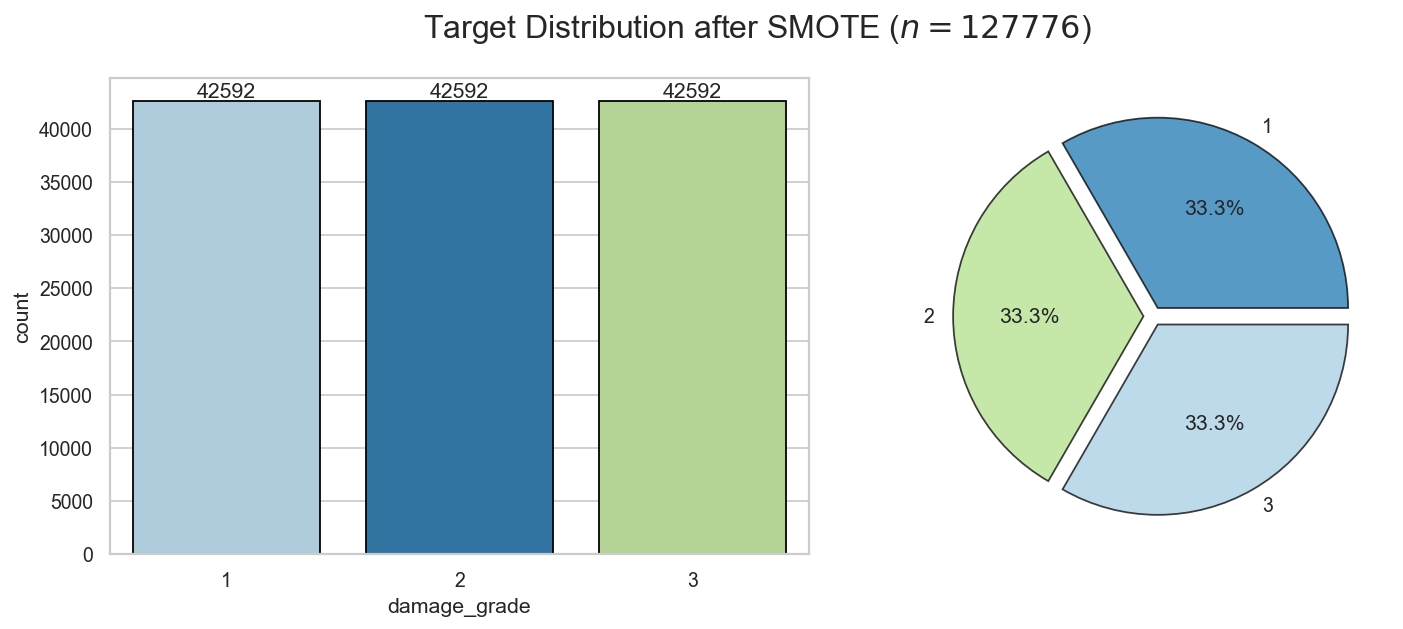

In [20]:
plot_target_distribution(y_train_res, title="Target Distribution after SMOTE")

In [21]:
model_post_smote, cv_results_post_smote = hyperparameter_optimization(model="XGBoost",
                                               train_data=X_train_res,
                                               train_labels=y_train_res,
                                               scoring=["accuracy", "matthews_corrcoef"])

Fitting XGBoost ...

CV Training ACC: 0.9906 +/- 0.0023 
CV Test ACC: 0.7864 +/- 0.1009

CV Training MCC: 0.9859 +/- 0.0034 
CV Test MCC: 0.6956 +/- 0.132



In [38]:
y_pred_post_smote = pd.DataFrame(model_post_smote.predict(X_val))

# Since XGBoost predicts [0, 1, 2] classes, we have to transform it to original class labels
if isinstance(model_post_smote, xgboost.XGBClassifier):
    print("XGBoost model was used. Renaming predictions ...")
    y_pred_post_smote = y_pred_post_smote.replace({0: 1, 1: 2, 2: 3})

acc_val_post = accuracy_score(y_true=y_val, y_pred=y_pred_post_smote)
mcc_val_post = matthews_corrcoef(y_true=y_val, y_pred=y_pred_post_smote)
print(f"ACC on validation set: {acc_val_post:.4f}")
print(f"MCC on validation set: {mcc_val_post:.4f}")

XGBoost model was used. Renaming predictions ...
ACC on validation set: 0.7134
MCC on validation set: 0.4680


In [50]:
def get_comparison_df(cv_results, cv_results_post) -> pd.DataFrame:
    mcc_test_pre = cv_results.get("test_matthews_corrcoef")
    mcc_test_post = cv_results_post.get("test_matthews_corrcoef")
    acc_test_pre = cv_results.get("test_accuracy")
    acc_test_post = cv_results_post.get("test_accuracy")

    df = pd.DataFrame({"acc_test_pre": acc_test_pre,
                       "acc_test_post": acc_test_post,
                       "mcc_test_pre": mcc_test_pre,
                       "mcc_test_post": mcc_test_post,})
    return df

df = get_comparison_df(cv_results, cv_results_post_smote)
df

,acc_test_pre,acc_test_post,mcc_test_pre,mcc_test_post
0,0.720533,0.596964,0.478346,0.452847
1,0.717000,0.792017,0.471772,0.694487
2,0.718800,0.798435,0.476376,0.701986
3,0.715133,0.873410,0.467968,0.815669
4,0.721600,0.871415,0.481746,0.812949


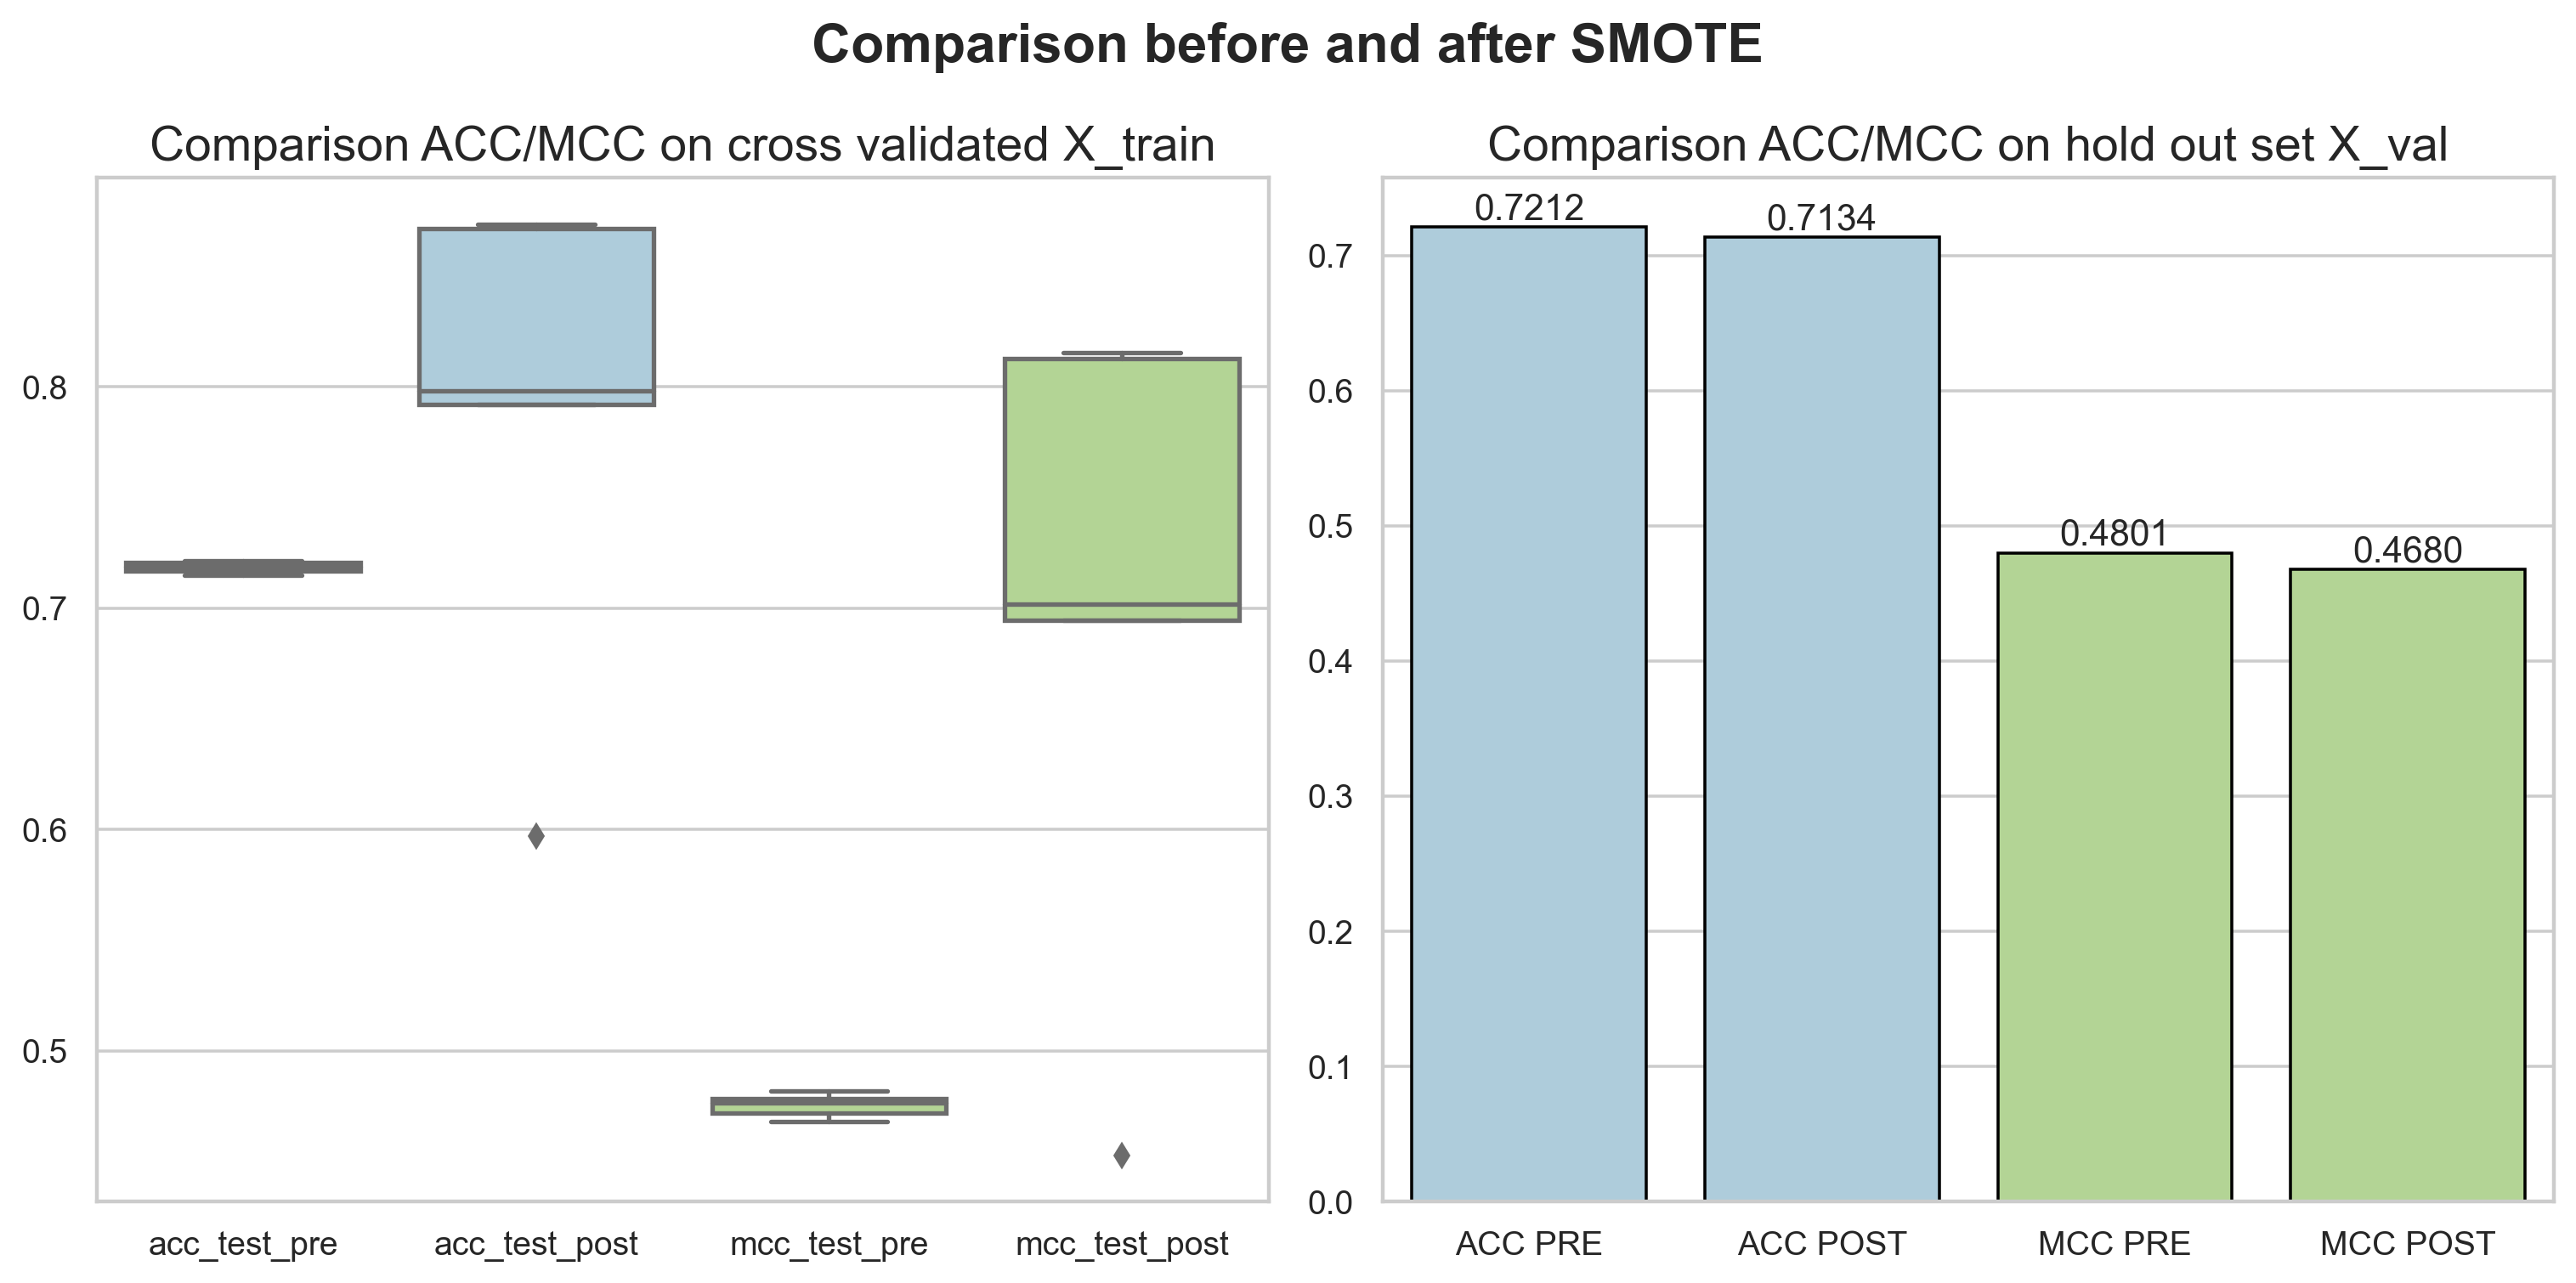

In [66]:
# Costum color for acc and mcc
custom_colors = ["#a6cee3", "#a6cee3", "#b2df8a", "#b2df8a"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6), dpi=256)
fig.suptitle("Comparison before and after SMOTE", fontweight="bold", size=18)
sns.boxplot(data=df, ax=axes[0], palette=custom_colors)
axes[0].set_title("Comparison ACC/MCC on cross validated X_train", size=16)
g = sns.barplot(x=["ACC PRE", "ACC POST", "MCC PRE", "MCC POST"],
            y=[acc_val_pre, acc_val_post, mcc_val_pre, mcc_val_post],
            edgecolor="black",
            ax=axes[1], palette=custom_colors)
axes[1].set_title("Comparison ACC/MCC on hold out set X_val", size=16)
g.bar_label(g.containers[0], fmt="%.4f")
plt.tight_layout()
plt.show()